In [1]:
q = """
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
"""             
from IPython.core.display import display, HTML
display(HTML(q))

# Decision Trees
Decision Trees (DTs) are a non-parametric supervised learning method used for both classification and regression. in that we split population or sample into homogeneous sets (sub-populations) based on differentiator in input features.

### What is Decision tree?
A decision tree is a tree where each node represents a feature(attribute), each link(branch) represents a decision(rule) and each leaf represents an outcome(categorical or continues value).<br>
The whole idea is to create a tree for the entire data and process a single outcome at every leaf.

### Working
Decision tree technique divides individual items of a group into n predetermined classes. Firstly, a feature is taken as the root node. This feature should best separate the classes. Then, each individual feature is divided into the given classes such that subpopulations called as nodes are generated. Same operation repeats on each new node obtained until no further separation of individuals are possible. Construction is such that each terminal node consists of individuals of a single class. More dipper understanding visit website: http://www.saedsayad.com/decision_tree_reg.htm for Decision tree - regression and http://www.saedsayad.com/decision_tree.htm for Decision Tree - Classification

### Types of decision tree
Types of decision tree is based on the type of target variable we have. It can be of two types:<br>
1. Categorical Variable Decision Tree: - Decision Tree which has categorical target variable then it called as categorical variable decision tree. <br>
2. Continuous Variable Decision Tree: - Decision Tree has continuous target variable then it is called as Continuous Variable Decision Tree.

### Methods to build decision tree
There are couple of algorithms there to build a decision tree
- ID3 (Iterative Dichotomiser 3)
- C4.5
- CART (Classification and Regression Trees)
- CHAID (CHi-squared Automatic Interaction Detector)
- MARS
- Conditional Inference Trees

we see about a few which are CART and ID3

## 1. Loading AnimalData  

In [2]:
#imports 
import pandas as pd
import pyodbc
import numpy as np
import scipy.stats as stats
import seaborn as sb
import matplotlib.pyplot as plt
import random
%matplotlib inline
pd.options.display.max_columns = None

In [3]:
#Style settings
pd.set_option('display.max_columns', None)
sb.set_style("whitegrid")
colors = ['yellowgreen', 'lightskyblue','lightcoral', 'gold', 'orange']
random_seed = 134

In [4]:
data_file = 'AnimalData.csv'

data_df = pd.read_csv(data_file, header=0)
data_df.head()

,animal name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type
0,aardvark,True,False,False,True,False,False,True,True,True,True,False,False,4,False,False,True,mammal
1,antelope,True,False,False,True,False,False,False,True,True,True,False,False,4,True,False,True,mammal
2,bass,False,False,True,False,False,True,True,True,True,False,False,True,0,True,False,False,fish
3,bear,True,False,False,True,False,False,True,True,True,True,False,False,4,False,False,True,mammal
4,boar,True,False,False,True,False,False,True,True,True,True,False,False,4,True,False,True,mammal


### Feature engineering
Covert true false data into 1 and 0

In [5]:
converter = {'True' : 1, 'False' : 0}

data_df['hair'] = data_df['hair'].astype(int)
data_df['feathers'] = data_df['feathers'].astype(int)
data_df['eggs'] = data_df['eggs'].astype(int)
data_df['milk'] = data_df['milk'].astype(int)
data_df['airborne'] = data_df['airborne'].astype(int)
data_df['aquatic'] = data_df['aquatic'].astype(int)
data_df['predator'] = data_df['predator'].astype(int)
data_df['toothed'] = data_df['toothed'].astype(int)
data_df['backbone'] = data_df['backbone'].astype(int)
data_df['breathes'] = data_df['breathes'].astype(int)
data_df['venomous'] = data_df['venomous'].astype(int)
data_df['fins'] = data_df['fins'].astype(int)
data_df['tail'] = data_df['tail'].astype(int)
data_df['domestic'] = data_df['domestic'].astype(int)
data_df['catsize'] = data_df['catsize'].astype(int)

In [6]:
data_df.head()

,animal name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,mammal
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,mammal
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,fish
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,mammal
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,mammal


### correlation matrix

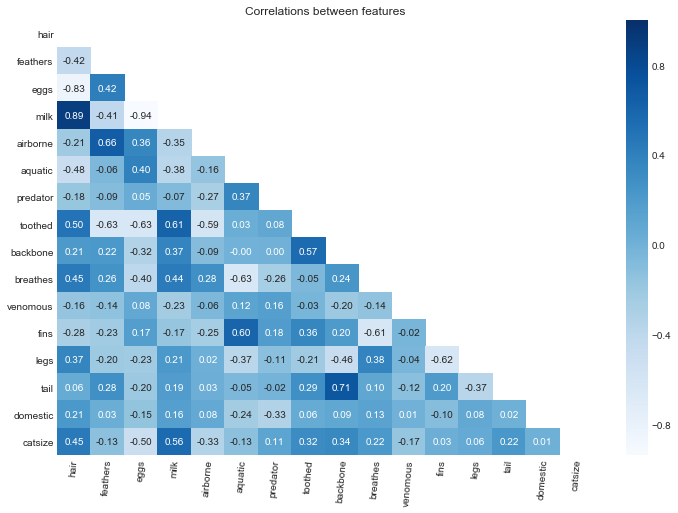

In [7]:
features_df = data_df.iloc[:, :-1]
target_df = data_df['type']

all_corr = features_df.corr(method = 'pearson')

mask = np.zeros_like(all_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = plt.figure(figsize=(12, 8))
ax = sb.heatmap(all_corr, cmap='Blues', annot=True, fmt='.2f', mask = mask)
ax = plt.xticks(rotation=85)
ax = plt.title("Correlations between features")

## 2. Training Model

The decision tree algorithm tries to solve the problem, by using tree representation. Each internal node of the tree corresponds to an attribute, and each leaf node corresponds to a class label.

#### Decision Tree Algorithm Pseudocode
1. Place the best attribute of the dataset at the root of the tree. In our case root node is milk attribute. 
2. Split the training set into subsets. Subsets should be made in such a way that each subset contains data with the same value for an attribute. (fins, toothed etc) 
3. Repeat step 1 and step 2 on each subset until you find leaf nodes in all the branches of the tree. Leaf nodes are target classes like in our case mammal, reptile, insect, bird.. 

#### Let's see in detail how it works
Algorithm first try to search for a variable which gives the maximum information gain or divides the data in the most homogeneous way. For example in our case milk attribute is dividing the data in the most homogeneous way. There are various metrics which decision trees use in order to find out the best split variables.  

### 1. CART (Classification and Regression Trees) → uses Gini Index(Classification) as metric.

In [8]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

for column in features_df.columns:
    if features_df[column].dtype == type(object):
        le = preprocessing.LabelEncoder()
        features_df[column] = le.fit_transform(features_df[column])

X_train, X_test, y_train, y_test = train_test_split(features_df, 
                                                    target_df, 
                                                    test_size=0.25)

print('X_train',X_train.shape)
print('X_test',X_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

X_train (72, 17)
X_test (25, 17)
y_train (72,)
y_test (25,)


In [9]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)

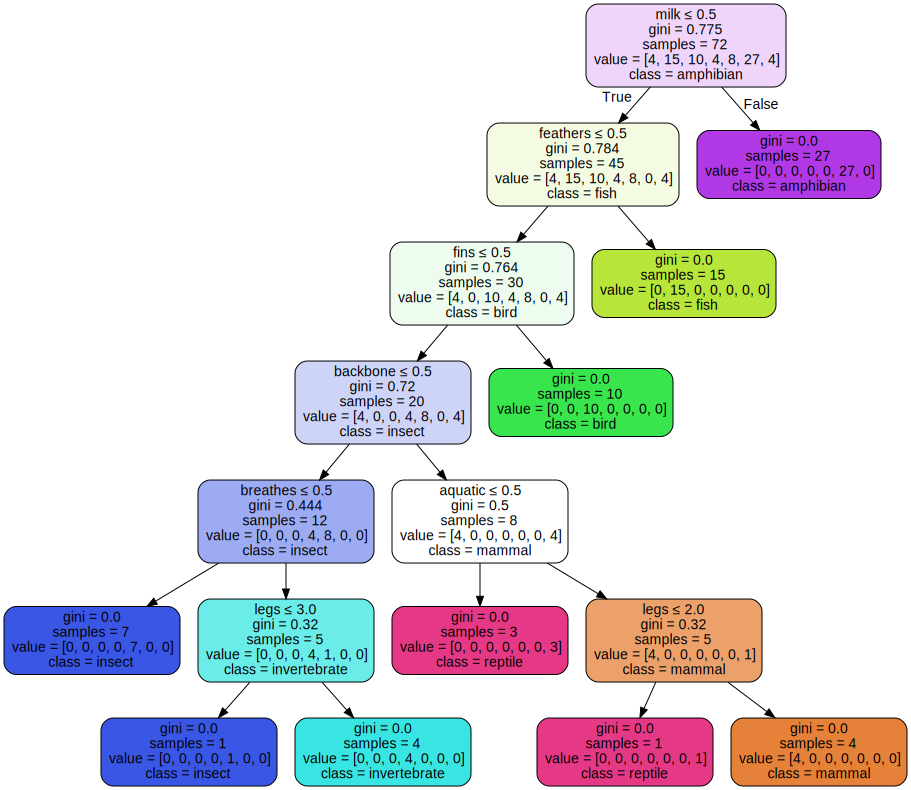

In [10]:
import graphviz

feature_names = list(features_df.columns.values)
target_names = target_df.unique()

dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=feature_names,
                         class_names=target_names,     
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)
graph

In [11]:
graph.render("AnimalData_graph")

'AnimalData_graph.pdf'

** Gini Index **
> $$ Gini Index = 1 - \sum_{i} p_j^2$$
> Gini Index is a metric to measure how often a randomly chosen element would be incorrectly identified.
It means an attribute with lower gini index should be preferred.
Sklearn supports “gini” criteria for Gini Index and by default, it takes “gini” value.

### 2. ID3 (Iterative Dichotomiser 3) → uses Entropy function and Information gain as metrics.

**Entropy**
> $$Entropy = -\sum_{i=1}^{N} p_i{x_i}log_2p(x_i)$$
> Entropy is the measure of uncertainty of a random variable, it characterizes the impurity of an arbitrary collection of examples. The higher the entropy the more the information content.

** Information Gain**
>The entropy typically changes when we use a node in a decision tree to partition the training instances into smaller subsets. Information gain is a measure of this change in entropy.
Sklearn supports “entropy” criteria for Information Gain and if we want to use Information Gain method in sklearn then we have to mention it explicitly.

In [12]:
clf_entropy = tree.DecisionTreeClassifier(
            criterion = "entropy", random_state = 100,
            max_depth = 3, min_samples_leaf = 5)
 
# Performing training
clf_entropy.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

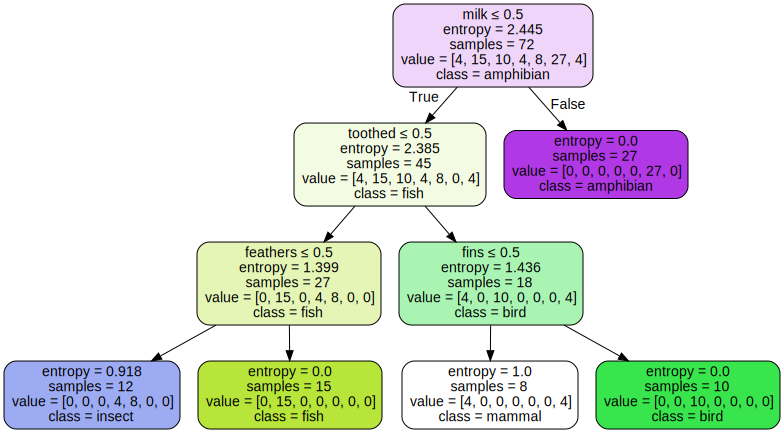

In [13]:
dot_data = tree.export_graphviz(clf_entropy, out_file=None, 
                         feature_names=feature_names,
                         class_names=target_names,     
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)
graph

** Entropy & Information Gain**


In [14]:
def entropy(attribute_data):
    """
    Calculate Shannon entropy
    :param attribute_data: data from a single feature/attribute
    :return: a float representing the Shannon entropy
    """
    _, val_freqs = np.unique(attribute_data, return_counts=True)
    # probabilities for each unique attribute value
    val_probs = val_freqs / len(attribute_data)
    return -val_probs.dot(np.log(val_probs))

def info_gain(attribute_data, labels):
    """
    Calculate information gain
    :param attribute_data: data from single attribute
    :param labels:
    :return: a float representing information gain
    """
    attr_val_counts = get_count_dict(attribute_data)
    total_count = len(labels)
    EA = 0.0
    for attr_val, attr_val_count in attr_val_counts.items():
        EA += attr_val_count * entropy(labels[attribute_data == attr_val])
    return entropy(labels) - EA / total_count

def get_count_dict(data):
    """
    Return the unique values and their frequencies as a dictionary
    :param data: a 1-D numpy array
    :return:
    """
    data_values, data_freqs = np.unique(data, return_counts=True)
    return dict(zip(data_values, data_freqs))

In [15]:
print("Info_gain for milk attribute:",info_gain(data_df['milk'],target_df))

Info_gain for milk attribute: 0.677709943131


** Note **<br>
I haven't implemented gini, entropy and info gain calculation method in this note book. But for calculation understanding you can refer the link https://www.dezyre.com/data-science-in-r-programming-tutorial/decision-tree-tutorial

There are other Metrics like Chi-square gain score etc.<br>
Next question or confusion arises when we have to choose any one of them. There are a few drawbacks associated with all  of the metrics based on the data we have to choose the matrices.
Some drawbacks of metrics are
- Information Gain:	Information Gain is biased towards multivariate attributes.
- Gain Ratio:	Gain Ratio generally prefers the unbalanced split of data where one of the child node has more number of entries compared to the others.
- Gini Index:	With more than 2 categories in the dataset, Gini Index gives unfavorable results. Apart from that it favors the split which results into equal sized children.

#### Prediction

In [16]:
y_pred = clf.predict(X_test)
print("Predicted values:")
print(y_pred)

Predicted values:
['mammal' 'mammal' 'bird' 'fish' 'insect' 'bird' 'mammal' 'mammal' 'mammal'
 'reptile' 'mammal' 'mammal' 'bird' 'mammal' 'mammal' 'insect' 'mammal'
 'fish' 'fish' 'mammal' 'mammal' 'bird' 'insect' 'mammal' 'insect']


## 3. Evaluation of classification metrics

#### 1. Accuracy score
In multilabel classification, the function returns the subset accuracy. If the entire set of predicted labels for a sample strictly match with the true set of labels, then the subset accuracy is 1.0; otherwise it is 0.0.

In [17]:
from sklearn.metrics import accuracy_score

print("Accuracy score for model is: ", accuracy_score(y_test, y_pred))

Accuracy score for model is:  0.96


In [18]:
# function to model it many times and build a distribution of scores
def accuracy_distribution(features, labels, num_reps, classifier):
    model_accuracies = []
    for rep in range(num_reps):
        (X_train_tmp, X_test_tmp, y_train_tmp, y_test_tmp) = train_test_split(features, labels, train_size=0.8, test_size=0.2)
        model_tmp = classifier
        model_tmp = model_tmp.fit(X_train_tmp, y_train_tmp)
        acc = model_tmp.score(X_test_tmp, y_test_tmp)
        model_accuracies.append(acc)

    ax = plt.figure(figsize=(14, 10))
    ax = sb.distplot(model_accuracies)
    ax = plt.title('Distribution of accuracies for {} runs'.format(num_reps))

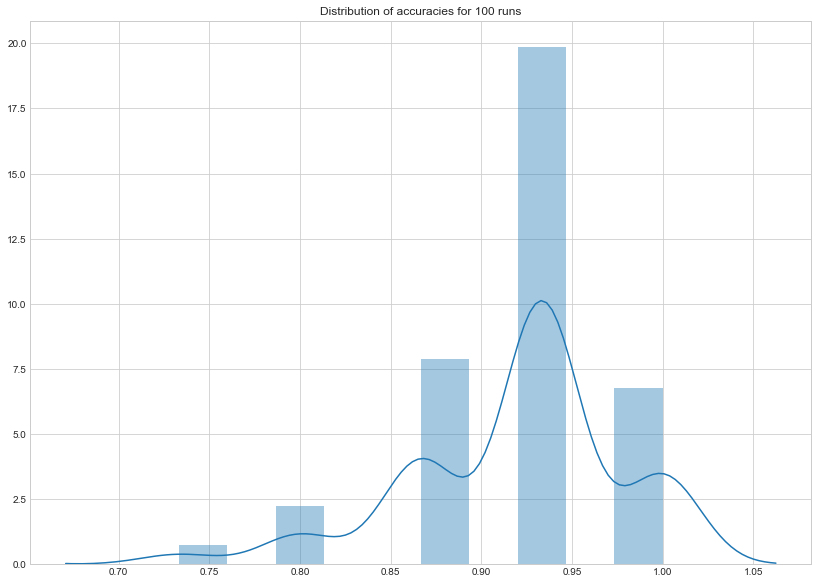

In [19]:
accuracy_distribution(X_train, y_train, 100, clf)

#### 2. Cohen's kappa
Cohen's kappa coefficient (κ) is a statistic which measures inter-rater agreement for qualitative (categorical) items. It is generally thought to be a more robust measure than simple percent agreement calculation, as κ takes into account the possibility of the agreement occurring by chance. <br>
The kappa score (see docstring) is a number between -1 and 1. Scores above .8 are generally considered good agreement; zero or lower means no agreement (practically random labels).

In [20]:
from sklearn.metrics import cohen_kappa_score

print("Cohen's kappa for our model is : ", cohen_kappa_score(y_test, y_pred))

Cohen's kappa for our model is :  0.94019138756


#### 3. Confusion matrix
also known as an error matrix, is a specific table layout that allows visualization of the performance of an algorithm. Each row of the matrix represents the instances in a predicted class while each column represents the instances in an actual class (or vice versa)

In [21]:
import itertools
from sklearn.metrics import confusion_matrix

# function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#        print("Normalized confusion matrix")
#    else:
#        print('Confusion matrix, without normalization')
#    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

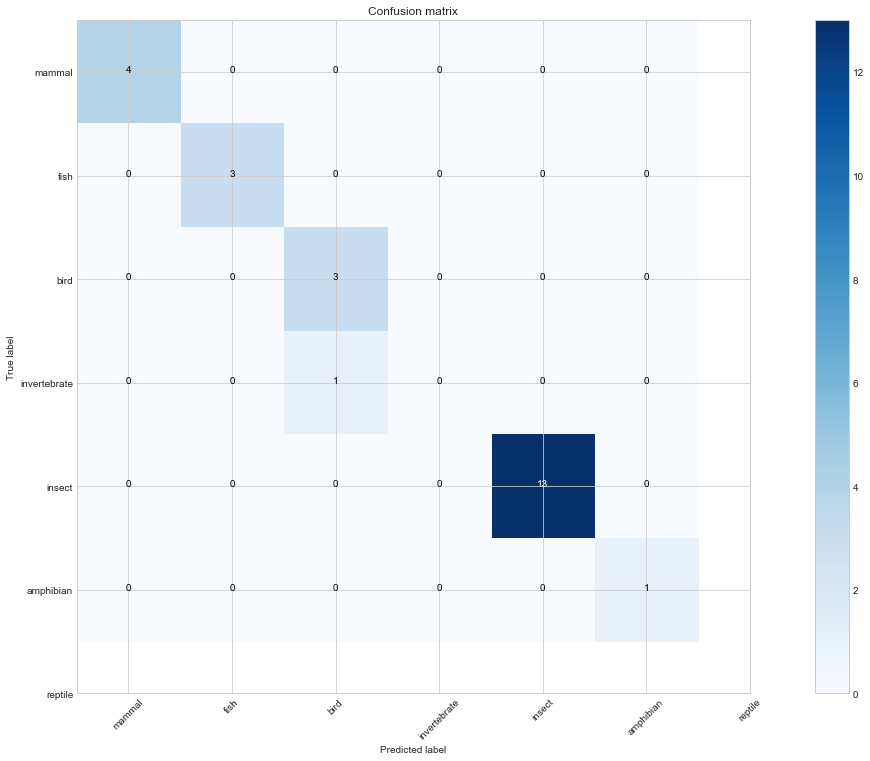

In [22]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=target_names, normalize=False, title='Confusion matrix')

#### 4. classification report

In [23]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        bird       1.00      1.00      1.00         4
        fish       1.00      1.00      1.00         3
      insect       0.75      1.00      0.86         3
invertebrate       0.00      0.00      0.00         1
      mammal       1.00      1.00      1.00        13
     reptile       1.00      1.00      1.00         1

 avg / total       0.93      0.96      0.94        25



C:\Users\jaypate\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Top 10 Most Important Features

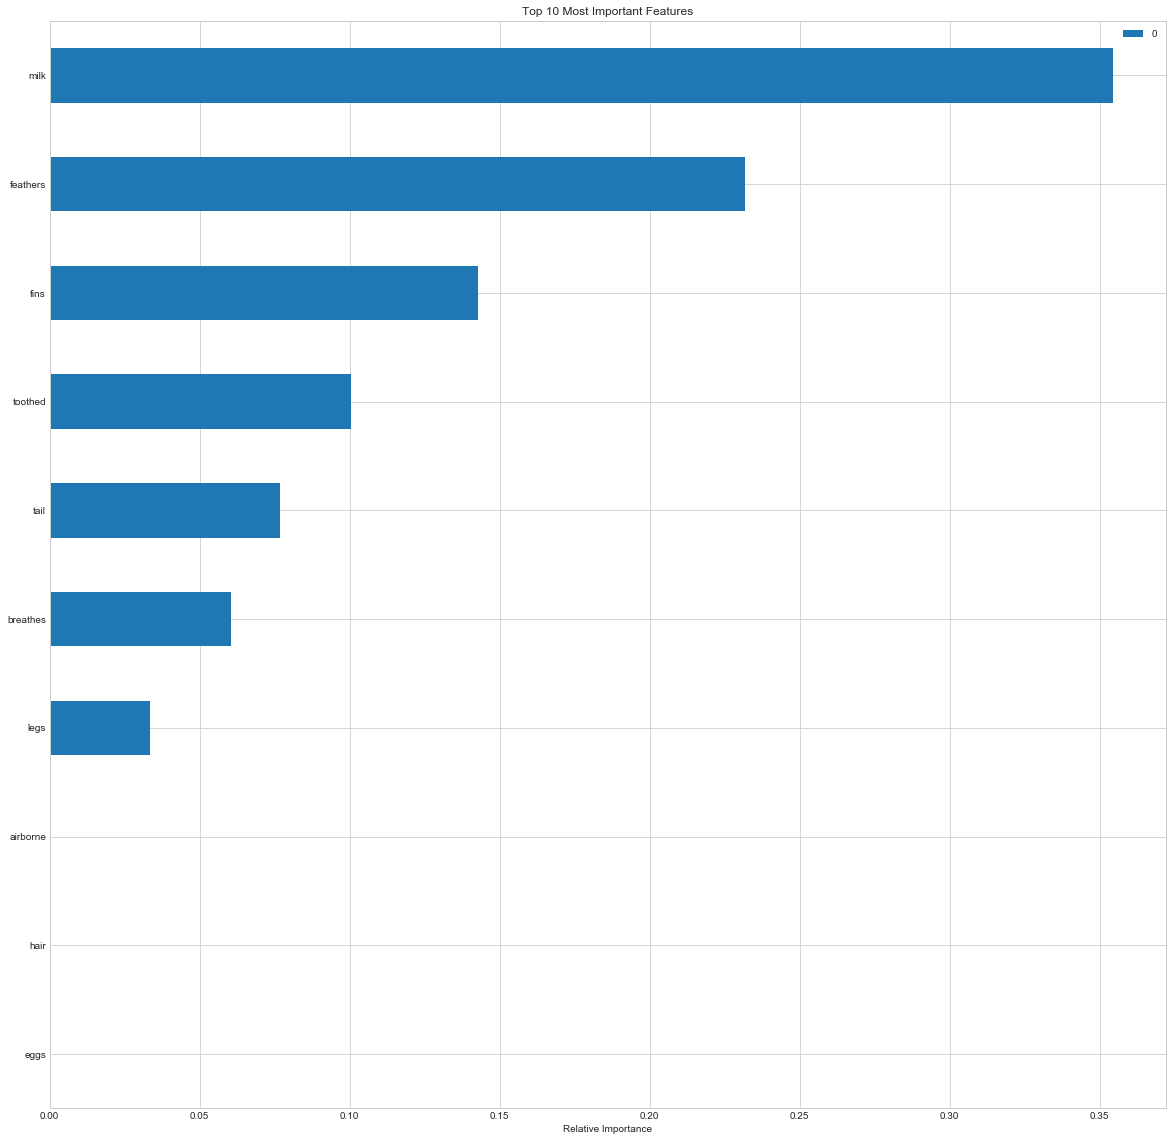

In [24]:
features = X_train.columns
importances = clf.feature_importances_
indices = np.argsort(importances)[-10:]
d = pd.DataFrame(importances[indices])

plt.rcParams["figure.figsize"] = (20,20)
ax = d.plot(kind = 'barh')
ax = plt.title('Top 10 Most Important Features')
ax = plt.yticks(range(len(indices)), features[indices])
ax = plt.xlabel('Relative Importance')